In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from erebus.individual_fit_results import IndividualFitResults
from erebus.joint_fit_results import JointFitResults
import glob

In [10]:
def get_results(folder):
	individual_fits = np.array([IndividualFitResults.load(file) for file in glob.glob(folder + "/*visit*.h5")])
	s = np.argsort([fit.start_time for fit in individual_fits])
	individual_fits = individual_fits[s]
	joint_fit_file = glob.glob(folder + "/*joint_fit.h5")
	if len(joint_fit_file) > 0:
		joint_fit = JointFitResults.load(joint_fit_file[0])
	else:
		joint_fit = None
	
	individual_fit_depths = [fit.results['fp'] * 1e6 for fit in individual_fits]
	joint_fit_depths = joint_fit.results['fp'] * 1e6 if joint_fit is not None else None

	return np.array(individual_fit_depths), joint_fit_depths

t1b_fnpca = get_results("t1b_fnpca")
t1b_exp = get_results("t1b_exp")

# T1C is the only one where we needed to force positive eclipse depths to ensure detection
t1c_fnpca_prevent_negative, _ = get_results("t1c_fnpca_prevent_negative")
t1c_fnpca_allow_negative, t1c_fnpca_joint_fit = get_results("t1c_fnpca_allow_negative")
t1c_exp_prevent_negative, _ = get_results("t1c_exp_prevent_negative")
t1c_exp_allow_negative, t1c_exp_joint_fit = get_results("t1c_exp_allow_negative")

t1c_fnpca = np.concatenate((t1c_fnpca_allow_negative[0:1], t1c_fnpca_prevent_negative[1:3], t1c_fnpca_allow_negative[3:4])), t1c_fnpca_joint_fit
t1c_exp = np.concatenate((t1c_exp_allow_negative[0:1], t1c_exp_prevent_negative[1:3], t1c_exp_allow_negative[3:4])), t1c_exp_joint_fit

lhs1478b_fnpca = get_results("lhs1478b_fnpca")
lhs1478b_exp = get_results("lhs1478b_exp")

toi1468b_fnpca = get_results("toi1468b_fnpca")
toi1468b_exp = get_results("toi1468b_exp")

lhs1140c_fnpca = get_results("lhs1140c_fnpca")
lhs1140c_exp = get_results("lhs1140c_exp")

In [11]:
def format_tuple_list(results):
	'''
	Functions for making the plot and table want a list of tuples
	'''
	array, joint_fit = results
	array = np.concatenate((array, [joint_fit]))
	return [(x.nominal_value, x.std_dev) if x is not None else None for x in array]

In [12]:
lhs1478b_lit = [(146, 56), None, (86, 66)]
toi_1468b_lit = [(239, 50, 53), (341, 52, 53), (357, 52, 52), (311, 31, 30)]
lhs_1140c_lit = [(327, 82), (215, 75), (272, 79), (273, 43)]

# The order goes 1->3->4->5->2 for 7,8,9,10,11
t1b_lit = [(790, 220), (510, 210), (950, 220), (820, 220), (820, 200), (861, 99)]

# The order goes 1 -> 4 -> 2 -> 3 for 1 2 3 4
t1c_lit = [(445, 193), (418, 173), (474, 158), (459, 185), (431, 97, 96)]

In [13]:
def plot_point(ax, x, y, upper_err, lower_err, color, marker):
	if lower_err is not None and lower_err != 0:
		yerr = ([upper_err], [lower_err])
	else:
		yerr = [upper_err]
	ax.errorbar(x, y, yerr=yerr, marker=marker, color=color, lw=2, capsize=3)

def plot_array(ax, label, color, lit, x_offset, marker='.'):
	visits = len(lit)-1
	mean = 0
	mean_err = 0
	mean_err_2 = 0
	non_none = 0

	ax.errorbar([], [], yerr=[], marker=marker, linestyle='', color=color, label=label, lw=2, capsize=3)
	
	for i in range(0, visits):
		visit = lit[i]
		if visit is not None:
			value = visit[0]
			err = visit[1]
			lower_err = visit[2] if len(visit) > 2 else None
			
			non_none += 1
			mean += value
			mean_err += err
			if len(visit) > 2:
				mean_err_2 += lower_err
			
			plot_point(ax, i + x_offset, value, err, lower_err, color, marker)
	mean /= non_none
	mean_err /= (non_none) * np.sqrt(non_none)
	mean_err_2 /= (non_none) * np.sqrt(non_none)
	if non_none > 1:
		plot_point(ax, visits + x_offset, mean, mean_err, mean_err_2, color, marker)

	joint_fit = lit[-1]
	if joint_fit is not None:
		joint_fit_y = joint_fit[0]
		joint_fit_y_err = joint_fit[1]
		joint_fit_y_err_lower = joint_fit[2] if len(joint_fit) > 2 else None
		plot_point(ax, visits + 1 + x_offset, joint_fit_y, joint_fit_y_err, joint_fit_y_err_lower, color, marker)

def plot_planet(ax, name, lit, fnpca, exp):
	fnpca = format_tuple_list(fnpca)
	exp = format_tuple_list(exp)
	
	plot_array(ax, "FN-PCA", "C0", fnpca, -0.15)
	plot_array(ax, "Exponential", "C1", exp, 0)
	plot_array(ax, "Literature", "dimgrey", lit, 0.15, 'x')
	length = len(lit)
	ticks = [i for i in range(0, length+1)]
	ax.set_xticks(ticks)
	labels = [f"Visit {i+1}" for i in range(0, length-1)] + ["Mean"] + ["Joint fit"]
	ax.set_xticklabels(labels, ha="right")
	ax.set_title(name)
	ax.axhline(0, color='black', zorder=0)
	ax.tick_params(axis='x', labelrotation=33)

	fnpca_jf_value = fnpca[-1][0]
	fnpca_jf_err = fnpca[-1][1]
	c = "cornflowerblue"
	ax.axhline(fnpca_jf_value, color=c, linestyle='--', zorder=1)
	ax.axhline(fnpca_jf_value + fnpca_jf_err, color=c, linestyle=':', zorder=1)
	ax.axhline(fnpca_jf_value - fnpca_jf_err, color=c, linestyle=':', zorder=1)
	ax.axhspan(fnpca_jf_value - fnpca_jf_err, fnpca_jf_value + fnpca_jf_err, color=c, alpha=0.2)

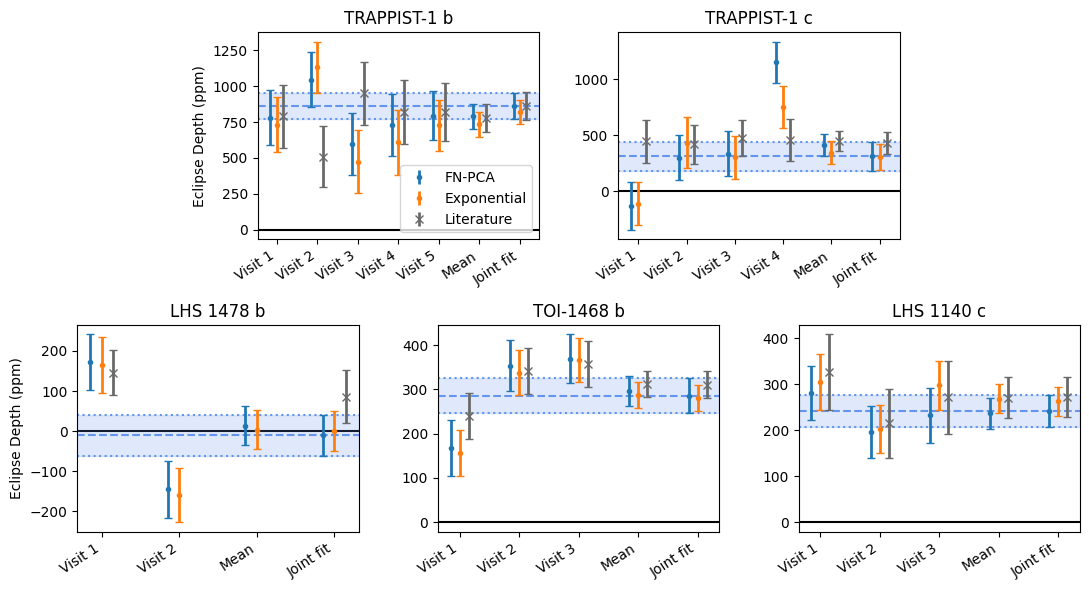

In [14]:
fig = plt.figure(figsize=(11,6))
gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 1:3])
ax2 = fig.add_subplot(gs[0, 3:5])
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

plot_planet(ax1, "TRAPPIST-1 b", t1b_lit, t1b_fnpca, t1b_exp)
plot_planet(ax2, "TRAPPIST-1 c", t1c_lit, t1c_fnpca, t1c_exp)
plot_planet(ax3, "LHS 1478 b", lhs1478b_lit, lhs1478b_fnpca, lhs1478b_exp)
plot_planet(ax4, "TOI-1468 b", toi_1468b_lit, toi1468b_fnpca, toi1468b_exp)
plot_planet(ax5, "LHS 1140 c", lhs_1140c_lit, lhs1140c_fnpca, lhs1140c_exp)
ax1.set_ylabel("Eclipse Depth (ppm)")
ax3.set_ylabel("Eclipse Depth (ppm)")
ax1.legend()
plt.tight_layout()
plt.savefig("eclipse_depth_results.pdf")
plt.show()

### Format table

In [15]:
def print_value(v):
	if v is None:
		return "-"
	if len(v) == 3:
		return f"${v[0]:0.0f}^{{+{v[1]:0.0f}}}_{{-{v[2]:0.0f}}}$"
	else:
		return f"{v[0]:0.0f} \\tpm {v[1]:0.0f}"

In [16]:
def get_mean(arr):
	mean = 0
	mean_err = 0
	mean_err_2 = 0
	non_none = 0
	for i in range(0, len(arr)-1):
		if arr[i] is None:
			continue
		mean += arr[i][0]
		mean_err += arr[i][1]
		if len(arr[i]) == 3:
			mean_err_2 += arr[i][2]
		non_none += 1
	mean /= non_none
	mean_err /= (non_none * np.sqrt(non_none))
	mean_err_2 /= (non_none * np.sqrt(non_none))

	if mean_err_2 != 0:
		return (mean, mean_err, mean_err_2)
	else:
		return (mean, mean_err)
		

def print_table(name, fnpca, exp, lit):
	fnpca = format_tuple_list(fnpca)
	exp = format_tuple_list(exp)
	
	visits = len(fnpca)-1
	text = f"\\multirow{{{(visits+2)}}}{{*}}{{\\textbf{{{name}}}}}\n"

	for v in range(0, visits):			
		text += f"& {(v+1)} & {print_value(fnpca[v])} & {print_value(exp[v])} & {print_value(lit[v])} \\\\\n"
	text += "\cline{2-5}\n"
	text += f"\\setrow{{\\bfseries}} & Mean & {print_value(get_mean(fnpca))} & {print_value(get_mean(exp))} & {print_value(get_mean(lit))} \\\\\n"
	text += f"\\setrow{{\\bfseries}} & Joint Fit & {print_value(fnpca[-1])} & {print_value(exp[-1])} & {print_value(lit[-1])} \\\\\\hline"
	print(text)
	
print_table("TRAPPIST-1\,b", t1b_fnpca, t1b_exp, t1b_lit)
print_table("TRAPPIST-1\,c", t1c_fnpca, t1c_exp, t1c_lit)
print_table("TOI-1468\,b", toi1468b_fnpca, toi1468b_exp, toi_1468b_lit)
print_table("LHS\,1478\,b", lhs1478b_fnpca, lhs1478b_exp, lhs1478b_lit)
print_table("LHS\,1140\,c", lhs1140c_fnpca, lhs1140c_exp, lhs_1140c_lit)

\multirow{7}{*}{\textbf{TRAPPIST-1\,b}}
& 1 & 780 \tpm 191 & 733 \tpm 192 & 790 \tpm 220 \\
& 2 & 1044 \tpm 192 & 1132 \tpm 178 & 510 \tpm 210 \\
& 3 & 599 \tpm 217 & 474 \tpm 219 & 950 \tpm 220 \\
& 4 & 728 \tpm 216 & 608 \tpm 225 & 820 \tpm 220 \\
& 5 & 795 \tpm 170 & 727 \tpm 180 & 820 \tpm 200 \\
\cline{2-5}
\setrow{\bfseries} & Mean & 789 \tpm 88 & 735 \tpm 89 & 778 \tpm 96 \\
\setrow{\bfseries} & Joint Fit & 863 \tpm 90 & 823 \tpm 83 & 861 \tpm 99 \\\hline
\multirow{6}{*}{\textbf{TRAPPIST-1\,c}}
& 1 & -131 \tpm 211 & -109 \tpm 190 & 445 \tpm 193 \\
& 2 & 301 \tpm 202 & 435 \tpm 230 & 418 \tpm 173 \\
& 3 & 335 \tpm 199 & 302 \tpm 193 & 474 \tpm 158 \\
& 4 & 1151 \tpm 182 & 753 \tpm 187 & 459 \tpm 185 \\
\cline{2-5}
\setrow{\bfseries} & Mean & 414 \tpm 99 & 345 \tpm 100 & 449 \tpm 89 \\
\setrow{\bfseries} & Joint Fit & 312 \tpm 128 & 306 \tpm 112 & $431^{+97}_{-96}$ \\\hline
\multirow{5}{*}{\textbf{TOI-1468\,b}}
& 1 & 168 \tpm 64 & 157 \tpm 52 & $239^{+50}_{-53}$ \\
& 2 & 354 \tpm 

### Trappist-1c 4 pixel

In [17]:
t1c_4_pixel = JointFitResults.load(glob.glob("t1c_4px/*joint_fit.h5")[0]).results['fp'] * 1e6
print(t1c_4_pixel.nominal_value, "+/-", t1c_4_pixel.std_dev)

337.1095091155011 +/- 140.72460600181444
